# EoR 21-cm Bispectrum Fisher analysis

Authors:
 
Leon Noble (phd2201121004@iiti.ac.in), IIT Indore

Yashrajsinh Mahida (phd2301121014@iiti.ac.in), IIT Indore

In [2]:
import numpy as np
import read_bs
import matplotlib.pyplot as plt
import corner

### Reading bispectrum data

In [3]:

# paths to the data
path_to_bs_data = "/home/leon/Documents/bs_fisher_inference_chapter/data/bs_data_out"
paths_params = [ "Lightcone_HII_EFF_FACTOR_400_Samples_Plus", "Lightcone_HII_EFF_FACTOR_400_Samples_Minus","Lightcone_ION_Tvir_MIN_400_Samples_Plus",
                "Lightcone_ION_Tvir_MIN_400_Samples_Minus", "Lightcone_R_BUBBLE_MAX_400_Samples_Plus", "Lightcone_R_BUBBLE_MAX_400_Samples_Minus"]
paths = [path_to_bs_data + "/" + path for path in paths_params]
bs_data_cov_path_ska_AA_star_1000 = "/home/leon/Documents/bs_fisher_inference_chapter/data/obs/ska_AA_star_1000/bs_data_out"
bs_data_cov_path_ska_AA_star_100 = "/home/leon/Documents/bs_fisher_inference_chapter/data/obs/ska_AA_star_100/bs_data_out"


In [32]:
# arrays to hold the data
num_k1_values = 40
num_samples = 399
n_params = 3
data_bs_unique = np.zeros((6,num_samples,num_k1_values,10,10))
data_bs_fidu_ska_AA_star_1000 = np.zeros((num_samples,num_k1_values,10,10)) 
data_bs_fidu_ska_AA_star_100 = np.zeros((num_samples,num_k1_values,10,10))
data_bs_squeezed = np.zeros((6,num_samples,num_k1_values))
data_bs_fidu_ska_AA_star_1000_squeezed = np.zeros((num_samples,num_k1_values))
data_bs_fidu_ska_AA_star_100_squeezed = np.zeros((num_samples,num_k1_values))
delta_params = [10, 10,pow(10,4.740362689494244)-pow(10,4.653212513775344) ] 

In [5]:
# reading  bispectrum data for all unique triangles and the squeezed limit for all realizations

for i in range(len(paths)):
    for j in range(num_samples):
       bs_data = read_bs.Auto_BS_Data("{}/realization_{}".format(paths[i], int(j)))
       k1_values, mu_bin, t_bin,data_bs_unique[i,j,:,:,:] , ntri, bispec = bs_data.read_bispec_data()
       data_bs_squeezed[i,j,:] = bs_data.get_squeezed_limit()
for j in range(num_samples):
    bs_data = read_bs.Auto_BS_Data("{}/realization_{}".format(bs_data_cov_path_ska_AA_star_1000, int(j)))
    k1_values, mu_bin, t_bin,data_bs_fidu_ska_AA_star_1000[j,:,:,:] , ntri, bispec = bs_data.read_bispec_data()
    data_bs_fidu_ska_AA_star_1000_squeezed[j,:] = bs_data.get_squeezed_limit()
    
for j in range(num_samples):
    bs_data = read_bs.Auto_BS_Data("{}/realization_{}".format(bs_data_cov_path_ska_AA_star_100, int(j)))
    k1_values, mu_bin, t_bin,data_bs_fidu_ska_AA_star_100[j,:,:,:] , ntri, bispec = bs_data.read_bispec_data()
    data_bs_fidu_ska_AA_star_100_squeezed[j,:] = bs_data.get_squeezed_limit()


In [6]:
# applying condition mu * t >= 0.50
index_list = []
for i in range(len(mu_bin)):
    for j in range(len(t_bin)):
        mu_t = mu_bin[i] * t_bin[j]
        if mu_t >= 0.50:
            index_list.append((i, j))
index_list = np.array(index_list)

# rearranging the bispectrum data
bs_data_unique_rearrange = np.zeros((6,399, np.size(k1_values), np.shape(index_list)[0]))
data_bs_fidu_ska_AA_star_1000_rearrange = np.zeros((num_samples, np.size(k1_values), np.shape(index_list)[0]))
data_bs_fidu_ska_AA_star_100_rearrange = np.zeros((num_samples, np.size(k1_values), np.shape(index_list)[0]))
for i in range(np.shape(index_list)[0]):
    bs_data_unique_rearrange[:,:,:, i] = data_bs_unique[:, :,:, index_list[i, 0], index_list[i, 1]]
    data_bs_fidu_ska_AA_star_1000_rearrange[:, :, i] = data_bs_fidu_ska_AA_star_1000[:, :,index_list[i, 0], index_list[i, 1]]
    data_bs_fidu_ska_AA_star_100_rearrange[:, :, i] = data_bs_fidu_ska_AA_star_100[:, :, index_list[i, 0], index_list[i, 1]]

### Finding the derivatives

In [7]:
# finding derivatives for the squeezed limit
der_sq_HII_EFF_sq = data_bs_squeezed[0, :, :] - data_bs_squeezed[1, :, :] / delta_params[0]
der_sq_Tvir_MIN_sq = data_bs_squeezed[2, :, :] - data_bs_squeezed[3, :, :] / delta_params[2]
der_sq_R_BUBBLE_MAX_sq = data_bs_squeezed[4, :, :] - data_bs_squeezed[5, :, :] / delta_params[1]



In [8]:
# finding derivatives for the bispectrum data for all unique triangles
der_bs_HII_EFF = bs_data_unique_rearrange[0, :, :, :] - bs_data_unique_rearrange[1, :, :, :] / delta_params[0]
der_bs_Tvir_MIN = bs_data_unique_rearrange[2, :, :, :] - bs_data_unique_rearrange[3, :, :, :] / delta_params[2]
der_bs_R_BUBBLE_MAX = bs_data_unique_rearrange[4, :, :, :] - bs_data_unique_rearrange[5, :, :, :] / delta_params[1]


### Estimating the Covariance

In [9]:
sigma_sq_SKA_AA_star_1000 = np.std(data_bs_fidu_ska_AA_star_1000_squeezed, axis=0) # sigma for squeezed limit (SKA AA star 1000)
sigma_sq_SKA_AA_star_100 = np.std(data_bs_fidu_ska_AA_star_100_squeezed, axis=0) # sigma for squeezed limit (SKA AA star 100)
#sigma_unique_SKA_AA_star_1000 = np.std(data_bs_fidu_ska_AA_star_1000, axis=(0))    # sigma for unique bispectrum (SKA AA star 1000)
#sigma_unique_SKA_AA_star_100 = np.std(data_bs_fidu_ska_AA_star_100, axis=(0))    # sigma for unique bispectrum (SKA AA star 100)

In [10]:
# applying mask to avoid unsampled k1 modes
mask_sq_SKA_AA_star_1000 = ~np.any(np.isnan(data_bs_fidu_ska_AA_star_1000_squeezed), axis=0)
data_bs_fidu_ska_AA_star_1000_squeezed_ = data_bs_fidu_ska_AA_star_1000_squeezed[:, mask_sq_SKA_AA_star_1000]
sigma_sq_ = sigma_sq_SKA_AA_star_1000[mask_sq_SKA_AA_star_1000]

In [11]:

sigma_unique_SKA_AA_star_1000 = np.zeros((np.shape(index_list)[0], np.size(k1_values)))
sigma_unique_SKA_AA_star_100 = np.zeros((np.shape(index_list)[0], np.size(k1_values)))
mask_unique_SKA_AA_star_1000 = np.zeros((np.shape(index_list)[0], np.size(k1_values)), dtype=bool) # masks to avoid unsampled k1 modes in the unique bispectrum data
mask_unique_SKA_AA_star_100 = np.zeros((np.shape(index_list)[0], np.size(k1_values)), dtype=bool) # masks to avoid unsampled k1 modes in the unique bispectrum data
for i in range(np.shape(index_list)[0]):
    sigma_unique_SKA_AA_star_1000[i, :] = np.std(data_bs_fidu_ska_AA_star_1000_rearrange[:, :, i], axis=0)
    mask_unique_SKA_AA_star_1000[i, :] = ~np.isnan(data_bs_fidu_ska_AA_star_1000_rearrange[:, :, i]).any(axis=0)
    sigma_unique_SKA_AA_star_100[i, :] = np.std(data_bs_fidu_ska_AA_star_100_rearrange[:, :, i], axis=0)
    mask_unique_SKA_AA_star_100[i, :] = ~np.isnan(data_bs_fidu_ska_AA_star_100_rearrange[:, :, i]).any(axis=0)

In [12]:
cov_field = data_bs_fidu_ska_AA_star_1000_squeezed_/sigma_sq_
cov_field_unique_SKA_AA_star_1000 = []
cov_field_unique_SKA_AA_star_100 = []
for j in range(np.shape(index_list)[0]):
    # SKA AA star 1000
    sliced_data_SKA_AA_Star_1000 = data_bs_fidu_ska_AA_star_1000_rearrange[:, :, j]
    maksed_data_SKA_AA_Star_1000 = sliced_data_SKA_AA_Star_1000[:, mask_unique_SKA_AA_star_1000[j]]
    cov_field_temp_SKA_AA_Star_1000 = maksed_data_SKA_AA_Star_1000 / sigma_unique_SKA_AA_star_1000[j][mask_unique_SKA_AA_star_1000[j]]
    cov_field_unique_SKA_AA_star_1000.append(cov_field_temp_SKA_AA_Star_1000)
    # SKA AA star 100
    sliced_data_SKA_AA_Star_100 = data_bs_fidu_ska_AA_star_100_rearrange[:, :, j]
    maksed_data_SKA_AA_Star_100 = sliced_data_SKA_AA_Star_100[:, mask_unique_SKA_AA_star_100[j]]
    cov_field_temp_SKA_AA_Star_100 = maksed_data_SKA_AA_Star_100 / sigma_unique_SKA_AA_star_100[j][mask_unique_SKA_AA_star_100[j]]
    cov_field_unique_SKA_AA_star_100.append(cov_field_temp_SKA_AA_Star_100)

        


In [14]:
covariance = np.cov(cov_field, rowvar=False)
print(f'log Condition number of the covariance matrix: {np.log10(np.linalg.cond(covariance)):.2f} (should be <= 7).')
covariance_unique_SKA_AA_star_1000 = []
covariance_unique_SKA_AA_star_100 = []
for j in range(np.shape(index_list)[0]):
    cov_temp_SKA_AA_star_1000 = np.cov(cov_field_unique_SKA_AA_star_1000[j], rowvar=False)
    cov_temp_SKA_AA_star_100 = np.cov(cov_field_unique_SKA_AA_star_100[j], rowvar=False)
    covariance_unique_SKA_AA_star_1000.append(cov_temp_SKA_AA_star_1000)
    covariance_unique_SKA_AA_star_100.append(cov_temp_SKA_AA_star_100)

    print(f'log Condition number of the covariance matrix: {np.log10(np.linalg.cond(cov_temp_SKA_AA_star_1000)):.2f} (should be <= 7).')
    print(f'log Condition number of the covariance matrix: {np.log10(np.linalg.cond(cov_temp_SKA_AA_star_100)):.2f} (should be <= 7).')


log Condition number of the covariance matrix: 0.55 (should be <= 7).
log Condition number of the covariance matrix: 0.54 (should be <= 7).
log Condition number of the covariance matrix: 0.54 (should be <= 7).
log Condition number of the covariance matrix: 0.39 (should be <= 7).
log Condition number of the covariance matrix: 0.42 (should be <= 7).
log Condition number of the covariance matrix: 0.41 (should be <= 7).
log Condition number of the covariance matrix: 0.38 (should be <= 7).
log Condition number of the covariance matrix: 0.44 (should be <= 7).
log Condition number of the covariance matrix: 0.47 (should be <= 7).
log Condition number of the covariance matrix: 0.38 (should be <= 7).
log Condition number of the covariance matrix: 0.38 (should be <= 7).
log Condition number of the covariance matrix: 0.39 (should be <= 7).
log Condition number of the covariance matrix: 0.43 (should be <= 7).
log Condition number of the covariance matrix: 0.44 (should be <= 7).
log Condition number

In [15]:
# for squeezed limit
deriv_field = np.zeros((n_params,num_samples,36))

deriv_field[0,:,:] = der_sq_Tvir_MIN_sq[:,4:]/sigma_sq_
deriv_field[1,:,:] = der_sq_R_BUBBLE_MAX_sq[:,4:]/sigma_sq_
deriv_field[2,:,:] = der_sq_HII_EFF_sq[:,4:]/sigma_sq_

# for unique bispectrum
deriv_field_unique_HII_EFF_SKA_AA_star_1000 = []
deriv_field_unique_Tvir_MIN_SKA_AA_star_1000 = []
deriv_field_unique_R_BUBBLE_MAX_SKA_AA_star_1000 = []
deriv_field_unique_HII_EFF_SKA_AA_star_100 = []
deriv_field_unique_Tvir_MIN_SKA_AA_star_100 = []
deriv_field_unique_R_BUBBLE_MAX_SKA_AA_star_100 = []


for j in range(np.shape(index_list)[0]):
    sliced__derv_field_HII_EFF = der_bs_HII_EFF[:, :, j]
    sliced__derv_field_Tvir_MIN = der_bs_Tvir_MIN[:, :, j]
    sliced__derv_field_R_BUBBLE_MAX = der_bs_R_BUBBLE_MAX[:, :, j]

    maksed_derv_field_HII_EFF_SKA_AA_star_1000 = sliced__derv_field_HII_EFF[:, mask_unique_SKA_AA_star_1000[j]]
    maksed_derv_field_Tvir_MIN_SKA_AA_star_1000 = sliced__derv_field_Tvir_MIN[:, mask_unique_SKA_AA_star_1000[j]]
    maksed_derv_field_R_BUBBLE_MAX_SKA_AA_star_1000 = sliced__derv_field_R_BUBBLE_MAX[:, mask_unique_SKA_AA_star_1000[j]]
    maksed_derv_field_HII_EFF_SKA_AA_star_100 = sliced__derv_field_HII_EFF[:, mask_unique_SKA_AA_star_100[j]]
    maksed_derv_field_Tvir_MIN_SKA_AA_star_100 = sliced__derv_field_Tvir_MIN[:, mask_unique_SKA_AA_star_100[j]]
    maksed_derv_field_R_BUBBLE_MAX_SKA_AA_star_100 = sliced__derv_field_R_BUBBLE_MAX[:, mask_unique_SKA_AA_star_100[j]]


    deriv_field_unique_HII_EFF_SKA_AA_star_1000.append(maksed_derv_field_HII_EFF_SKA_AA_star_1000 / sigma_unique_SKA_AA_star_1000[j][mask_unique_SKA_AA_star_1000[j]])
    deriv_field_unique_Tvir_MIN_SKA_AA_star_1000.append(maksed_derv_field_Tvir_MIN_SKA_AA_star_1000 / sigma_unique_SKA_AA_star_1000[j][mask_unique_SKA_AA_star_1000[j]])
    deriv_field_unique_R_BUBBLE_MAX_SKA_AA_star_1000.append(maksed_derv_field_R_BUBBLE_MAX_SKA_AA_star_1000 / sigma_unique_SKA_AA_star_1000[j][mask_unique_SKA_AA_star_1000[j]])
    deriv_field_unique_HII_EFF_SKA_AA_star_100.append(maksed_derv_field_HII_EFF_SKA_AA_star_100 / sigma_unique_SKA_AA_star_100[j][mask_unique_SKA_AA_star_100[j]])
    deriv_field_unique_Tvir_MIN_SKA_AA_star_100.append(maksed_derv_field_Tvir_MIN_SKA_AA_star_100 / sigma_unique_SKA_AA_star_100[j][mask_unique_SKA_AA_star_100[j]])
    deriv_field_unique_R_BUBBLE_MAX_SKA_AA_star_100.append(maksed_derv_field_R_BUBBLE_MAX_SKA_AA_star_100 / sigma_unique_SKA_AA_star_100[j][mask_unique_SKA_AA_star_100[j]])


In [62]:
samples = np.arange(5, num_samples+5, 5)
BS_Fisher_SKA_AA_star_1000 = np.zeros((np.shape(index_list)[0],samples.shape[0], n_params, n_params))
BS_Fisher_SKA_AA_star_100 = np.zeros((np.shape(index_list)[0],samples.shape[0], n_params, n_params))
BS_Fisher_unique_SKA_AA_star_1000 = np.zeros((samples.shape[0], n_params, n_params))
BS_Fisher_unique_SKA_AA_star_100 = np.zeros((samples.shape[0], n_params, n_params))
# calculating the Fisher matrix for all unique triangles
for i in range(np.shape(index_list)[0]):
    # SKA AA star 1000
    deriv_field_specific_config_SKA_AA_star_1000 = np.zeros((n_params, num_samples, np.shape(deriv_field_unique_HII_EFF_SKA_AA_star_1000[i])[-1]))
    deriv_field_specific_config_SKA_AA_star_1000[0, :, :] = deriv_field_unique_HII_EFF_SKA_AA_star_1000[i]
    deriv_field_specific_config_SKA_AA_star_1000[1, :, :] = deriv_field_unique_Tvir_MIN_SKA_AA_star_1000[i]
    deriv_field_specific_config_SKA_AA_star_1000[2, :, :] = deriv_field_unique_R_BUBBLE_MAX_SKA_AA_star_1000[i]
    covariance_specific_SKA_AA_star_1000 = covariance_unique_SKA_AA_star_1000[i]
    # SKA AA star 100
    deriv_field_specific_config_SKA_AA_star_100 = np.zeros((n_params, num_samples, np.shape(deriv_field_unique_HII_EFF_SKA_AA_star_100[i])[-1]))
    deriv_field_specific_config_SKA_AA_star_100[0, :, :] = deriv_field_unique_HII_EFF_SKA_AA_star_100[i]
    deriv_field_specific_config_SKA_AA_star_100[1, :, :] = deriv_field_unique_Tvir_MIN_SKA_AA_star_100[i]
    deriv_field_specific_config_SKA_AA_star_100[2, :, :] = deriv_field_unique_R_BUBBLE_MAX_SKA_AA_star_100[i]
    covariance_specific_SKA_AA_star_100 = covariance_unique_SKA_AA_star_100[i]
    # calculating the Fisher matrix for all samples

    for k, sample in enumerate(samples):

        deriv_sample_specific_SKA_AA_star_1000 = np.mean(deriv_field_specific_config_SKA_AA_star_1000[:, :sample, :], axis=1)
        deriv_sample_specific_SKA_AA_star_100 = np.mean(deriv_field_specific_config_SKA_AA_star_100[:, :sample, :], axis=1)

        for j in range(n_params):
            for l in range(n_params):

                BS_Fisher_SKA_AA_star_1000[i, k, j, l] = np.dot(deriv_sample_specific_SKA_AA_star_1000[j], np.dot(np.linalg.inv(covariance_specific_SKA_AA_star_1000), deriv_sample_specific_SKA_AA_star_1000[l]))
                BS_Fisher_SKA_AA_star_100[i, k, j, l] = np.dot(deriv_sample_specific_SKA_AA_star_100[j], np.dot(np.linalg.inv(covariance_specific_SKA_AA_star_100), deriv_sample_specific_SKA_AA_star_100[l]))




In [63]:
BS_Fisher_unique_SKA_AA_star_1000 =  np.sum(BS_Fisher_SKA_AA_star_1000, axis=0)
BS_Fisher_unique_SKA_AA_star_100 =  np.sum(BS_Fisher_SKA_AA_star_100, axis=0)
BS_Fisher_INV_SKA_AA_star_1000 = np.zeros((samples.shape[0], n_params, n_params))
BS_Fisher_INV_SKA_AA_star_100 = np.zeros((samples.shape[0], n_params, n_params))
for i, sample in enumerate(samples):
    BS_Fisher_INV_SKA_AA_star_1000[i] = np.linalg.inv(BS_Fisher_unique_SKA_AA_star_1000[i])
    BS_Fisher_INV_SKA_AA_star_100[i] = np.linalg.inv(BS_Fisher_unique_SKA_AA_star_100[i])


In [65]:


fid = [50118.72336272725,15,30]
fisher_data = np.random.multivariate_normal(fid, BS_Fisher_INV_SKA_AA_star_1000[-1], size=50000)



In [66]:
Fisher_Param = ['$T_{Vir}$','$R_{Max}$','$\zeta$']

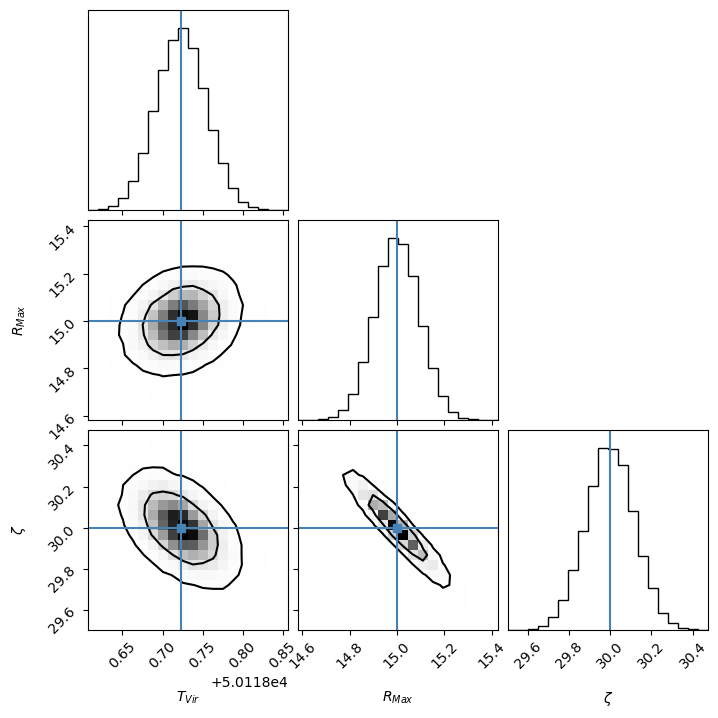

In [67]:


_ = corner.corner(
    fisher_data,
    labels=Fisher_Param,
    plot_datapoints=False,  
    levels=(0.68,0.95),
    truths=fid)